# これがメインのファイルです

In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [31]:
def pos_neg(team, nlead=3, nbehind=4, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, nlead, 7, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -nbehind, -1, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [32]:
#pos_neg("インディアンス", year=2017)

In [33]:
res = []
for team in teams_mlb:
    curr = pos_neg(team, year=2018)
    curr[0] = curr[0] + "2018"
    res.append(curr)
    print(curr[0])
    curr = pos_neg(team, year=2017)
    curr[0] = curr[0] + "2017"
    res.append(curr)
    print(curr[0])

レッズ2018
レッズ2017
ヤンキース2018
ヤンキース2017
ブルージェイズ2018
ブルージェイズ2017
メッツ2018
メッツ2017
Rソックス2018
Rソックス2017
パイレーツ2018
パイレーツ2017
アスレチックス2018
アスレチックス2017
ドジャース2018
ドジャース2017
ロッキーズ2018
ロッキーズ2017
インディアンス2018
インディアンス2017
レイズ2018
レイズ2017
Dバックス2018
Dバックス2017
タイガース2018
タイガース2017
ロイヤルズ2018
ロイヤルズ2017
ジャイアンツ2018
ジャイアンツ2017
アストロズ2018
アストロズ2017
Wソックス2018
Wソックス2017
レンジャーズ2018
レンジャーズ2017
パドレス2018
パドレス2017
ブリュワーズ2018
ブリュワーズ2017
エンゼルス2018
エンゼルス2017
マリナーズ2018
マリナーズ2017
ナショナルズ2018
ナショナルズ2017
ツインズ2018
ツインズ2017
カブス2018
カブス2017
オリオールズ2018
オリオールズ2017
ブレーブス2018
ブレーブス2017
カージナルス2018
カージナルス2017
フィリーズ2018
フィリーズ2017
マーリンズ2018
マーリンズ2017


In [34]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [35]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

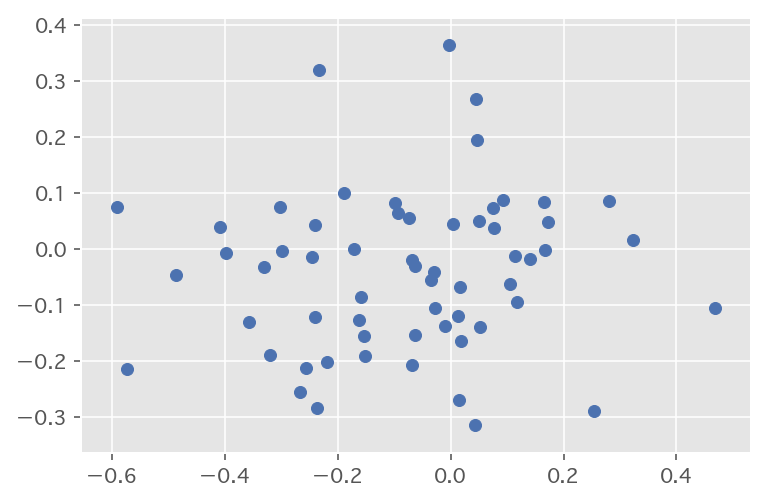

In [36]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [37]:
df

,all_imp,all_det,pos_imp,pos_det,neg_imp,neg_det,positive_inhibition,negative_facilitation
チーム,,,,,,,,
レッズ2018,0.840548,0.714499,0.908370,0.444979,0.664466,0.694124,-0.067823,-0.020375
レッズ2017,0.903545,0.934222,0.859426,1.104853,0.713268,0.619655,0.044118,-0.314567
ヤンキース2018,1.161285,1.136856,1.147093,1.366944,0.927381,0.866718,0.014192,-0.270138
ヤンキース2017,1.029821,0.863357,1.269614,1.070321,0.795191,0.741985,-0.239794,-0.121372
ブルージェイズ2018,0.862896,1.100316,0.873197,1.200726,0.820970,0.963120,-0.010300,-0.137195
ブルージェイズ2017,1.017999,0.931079,0.901085,1.056555,1.081197,0.836765,0.116914,-0.094314
メッツ2018,0.871277,0.827845,0.698510,0.842646,0.806665,0.875683,0.172767,0.047838
メッツ2017,0.876622,1.093379,0.903504,0.977578,0.921067,0.987644,-0.026881,-0.105734
Rソックス2018,0.911387,0.937122,0.913801,0.982609,0.977283,1.300632,-0.002414,0.363510


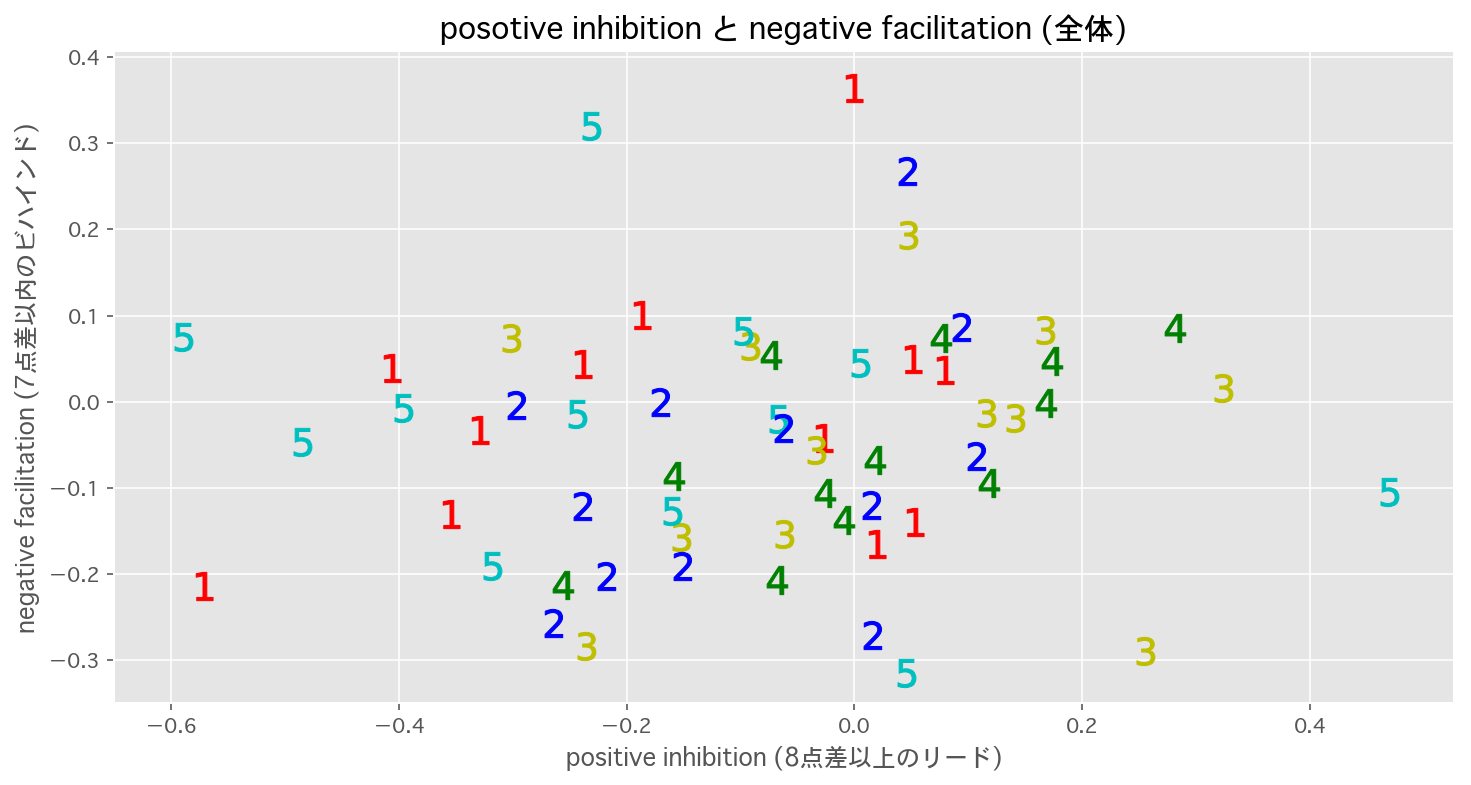

In [38]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team[:-4], int(team[-4:]))), color=colors[ranking(team[:-4], int(team[-4:]))-1], s=200)
plt.title("posotive inhibition と negative facilitation (全体)", fontsize=15)
plt.xlabel("positive inhibition (8点差以上のリード)")
plt.ylabel("negative facilitation (7点差以内のビハインド)")

In [39]:
order_pos_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_pos_dict[ranking(team, year)] += df.loc[teamyear, "positive_inhibition"]

In [40]:
order_pos_dict

defaultdict(int,
            {1: -1.9292990911551358,
             2: -1.1381347701390063,
             3: 0.1630681119276256,
             4: 0.23447359152261671,
             5: -2.0797671852707351})

In [41]:
order_neg_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_neg_dict[ranking(team, year)] += df.loc[teamyear, "negative_facilitation"]

In [42]:
order_neg_dict

defaultdict(int,
            {1: -0.090015649764818573,
             2: -0.90354999196291752,
             3: -0.53885691975705485,
             4: -0.64965265126721383,
             5: -0.30270420318058766})

In [43]:
res_df = pd.DataFrame(np.array([list(order_pos_dict.values()), list(order_neg_dict.values())]), columns=[1, 2, 3, 4, 5], index=["positive_inhibition", "negative_facilitation"]).T

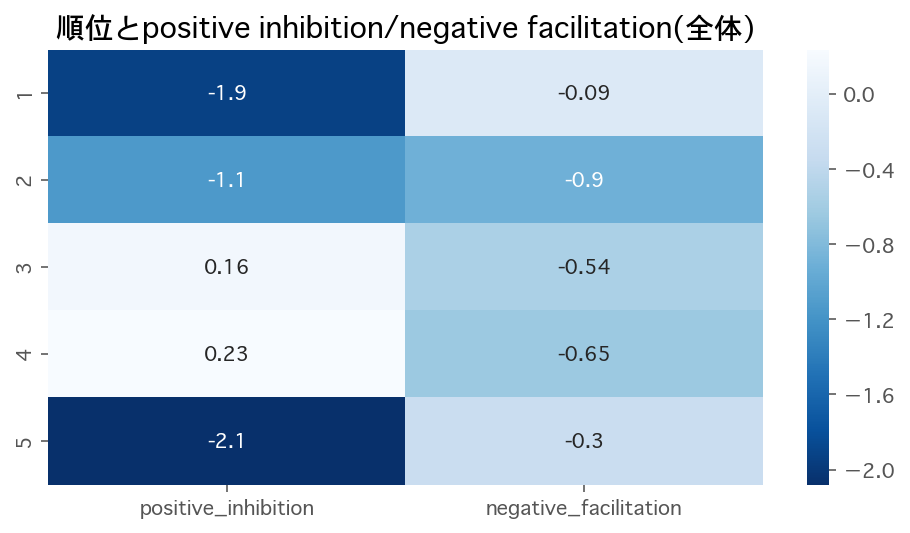

In [44]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.heatmap(res_df, cmap='Blues_r', annot=True)
plt.title("順位とpositive inhibition/negative facilitation(全体)")

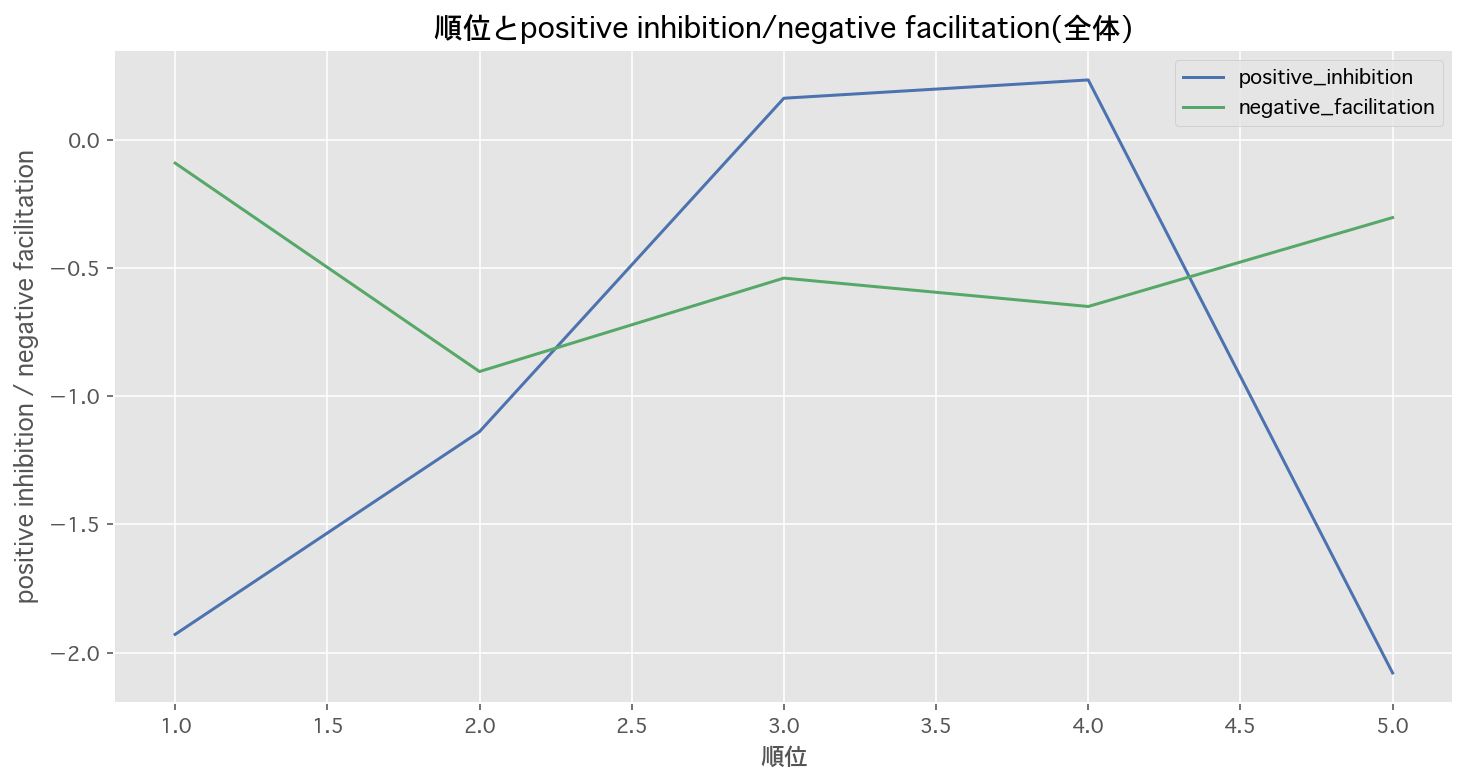

In [45]:
pd.DataFrame([list(order_pos_dict.values()), list(order_neg_dict.values())], index=["positive_inhibition", "negative_facilitation"], columns=[1, 2, 3, 4, 5]).T.plot(figsize=(12, 6))
plt.title("順位とpositive inhibition/negative facilitation(全体)")
plt.xlabel("順位")
plt.ylabel("positive inhibition / negative facilitation")

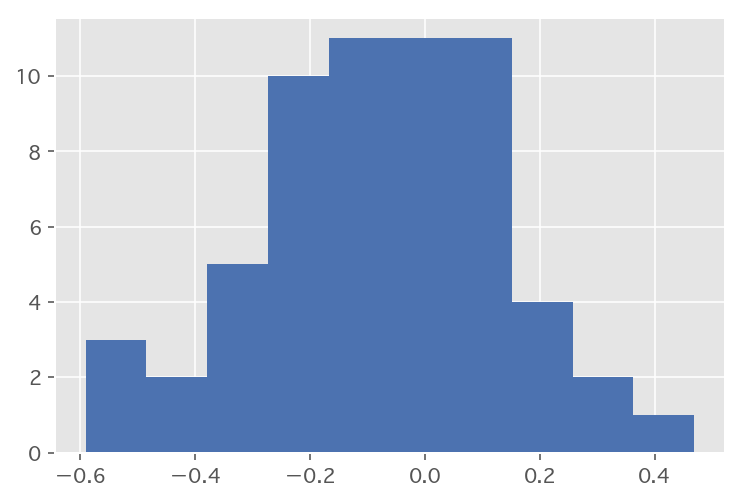

In [46]:
df.loc[:, "positive_inhibition"].hist()

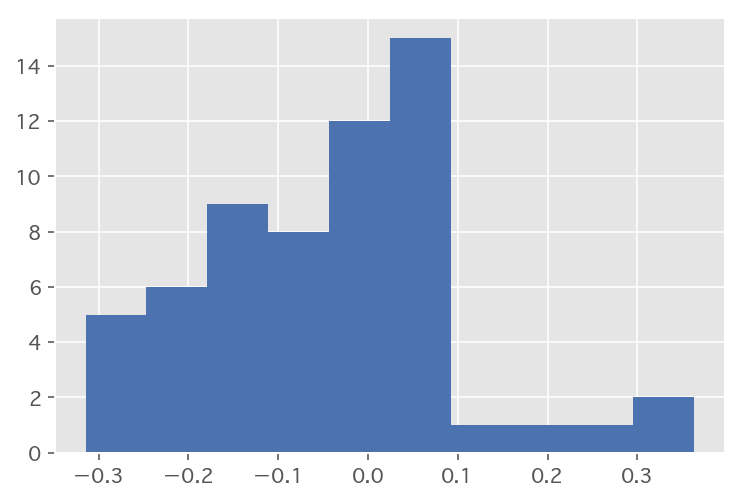

In [47]:
df.loc[:, "negative_facilitation"].hist()

In [48]:
def test(merged_array, title="", xlabel="", ylabel=""):
    x = merged_array[:, 0] #説明変数
    y = merged_array[:, 1] #目的変数
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    a = results.params[0]
    b = results.params[1]
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, color="b")
    plt.plot(x, a+b*x)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    print("p-values : ", results.pvalues)

In [49]:
winning_rate_df = pd.read_csv(os.path.join(DATA_DIR, "winning_rate.csv"), index_col=0)
        
def winning_rate(team, year=2018):
    # year = 2018 or 2017 or "mean"
    return winning_rate_df[str(year)][team]

### 勝率とpositive inhibitionの関係

In [50]:
df_year = df[df.index.str.contains(str(2018))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = pd.concat([df_year, winning_rate_df[[str(2018)]]], axis=1).values
df_year = df[df.index.str.contains(str(2017))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = np.concatenate([merged_array, pd.concat([df_year, winning_rate_df[[str(2017)]]], axis=1).values])

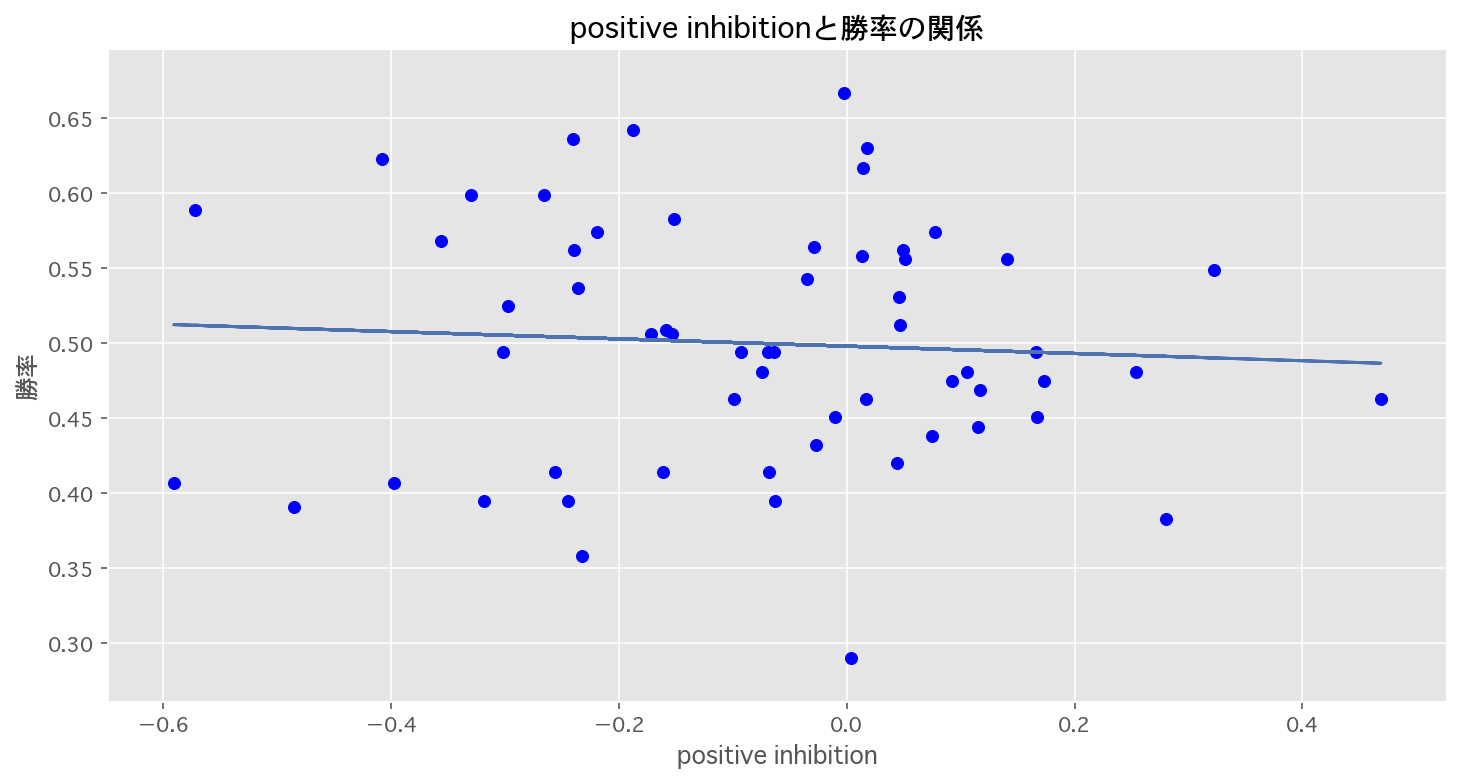

p-values :  [  1.54845018e-46   6.24905466e-01]


In [51]:
test(merged_array, "positive inhibitionと勝率の関係", "positive inhibition", "勝率")

In [52]:
x = merged_array[:, 0] #説明変数
y = merged_array[:, 1] #目的変数
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
results.rsquared

0.0041482965214698631

### 勝率とnegative facilitationの関係

In [53]:
df_year = df[df.index.str.contains(str(2018))][["negative_facilitation"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = pd.concat([df_year, winning_rate_df[[str(2018)]]], axis=1).values
df_year = df[df.index.str.contains(str(2017))][["negative_facilitation"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = np.concatenate([merged_array, pd.concat([df_year, winning_rate_df[[str(2017)]]], axis=1).values])

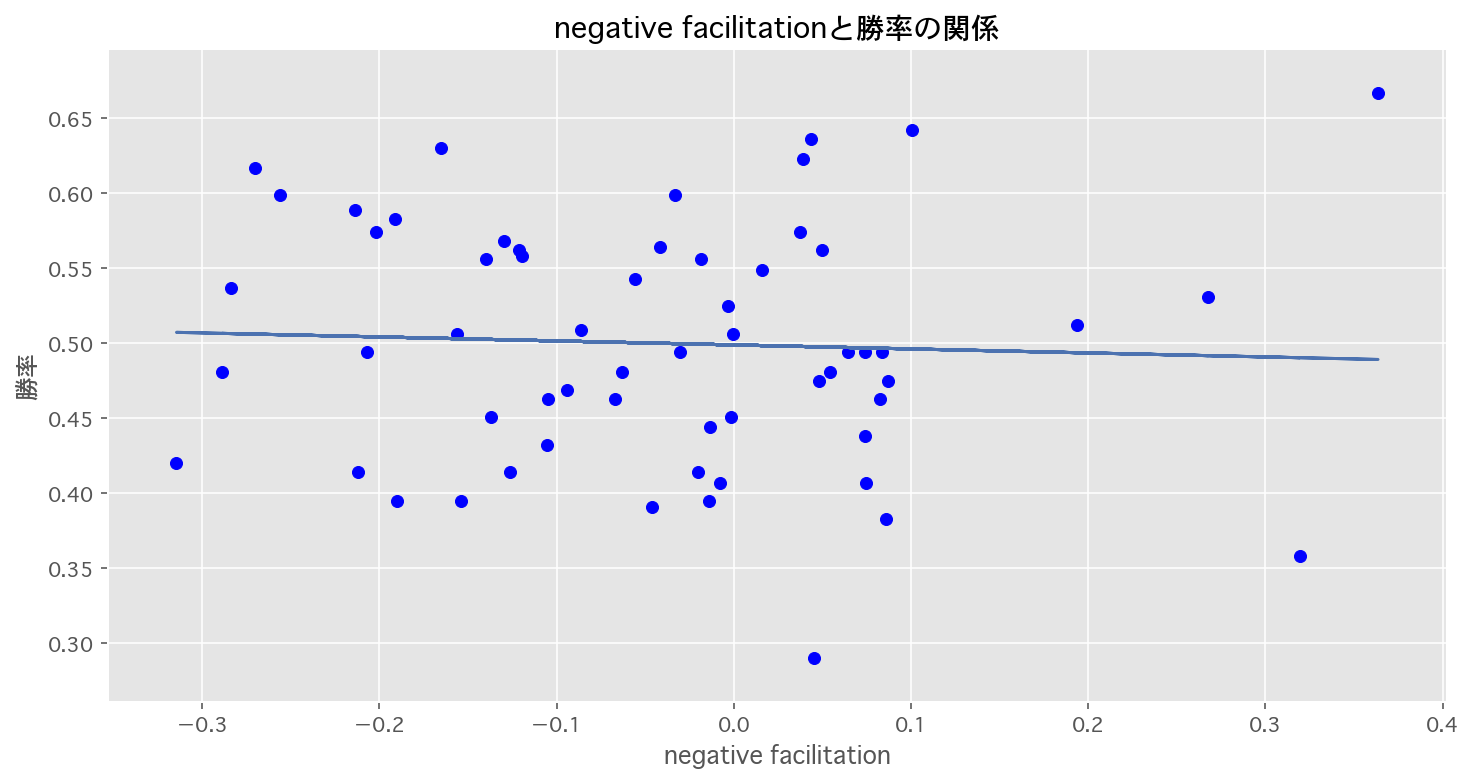

p-values :  [  3.84612137e-47   7.20804178e-01]


In [54]:
test(merged_array, "negative facilitationと勝率の関係", "negative facilitation", "勝率")

In [55]:
x = merged_array[:, 0] #説明変数
y = merged_array[:, 1] #目的変数
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
results.rsquared

0.0022187255360843761

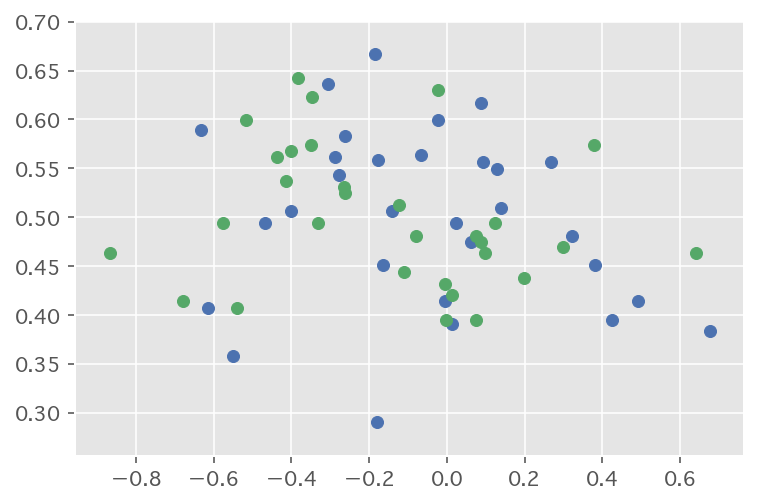

In [28]:
# 勝率とpositive inhibitionの関係
year = 2018
df_year = df[df.index.str.contains(str(year))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
plt.scatter(merged_df.positive_inhibition, merged_df[str(year)])

year = 2017
df_year = df[df.index.str.contains(str(year))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
plt.scatter(merged_df.positive_inhibition, merged_df[str(year)])

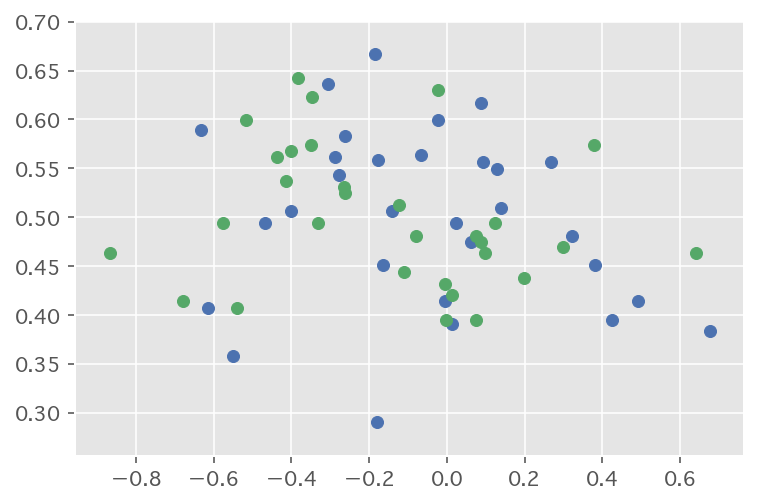

In [29]:
# 勝率とpositive inhibitionの関係
merged_df = None
for year in [2018, 2017]:
    df_year = df[df.index.str.contains(str(year))][["positive_inhibition"]]
    df_year.index = [elem[:-4] for elem in list(df_year.index)]
    merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
    plt.scatter(merged_df.positive_inhibition, merged_df[str(year)])
plt.show()

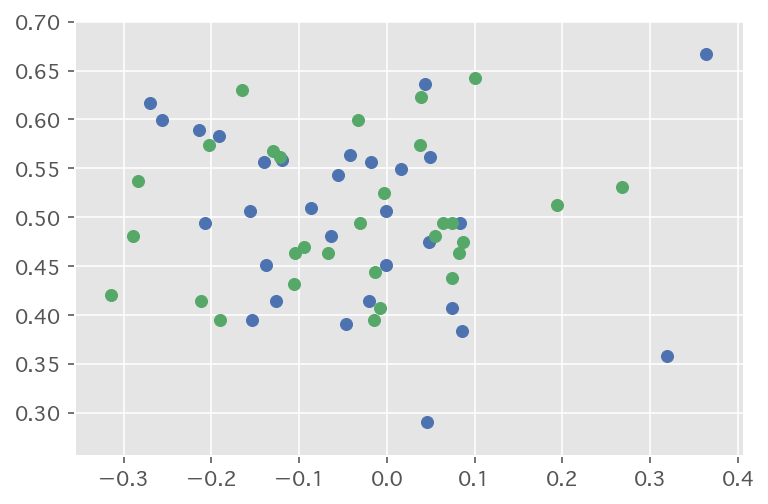

In [30]:
# 勝率とnegative facilitationの関係
for year in [2018, 2017]:
    df_year = df[df.index.str.contains(str(year))][["negative_facilitation"]]
    df_year.index = [elem[:-4] for elem in list(df_year.index)]
    merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
    plt.scatter(merged_df.negative_facilitation, merged_df[str(year)])